# Binary-Class Image Classification Deep Learning Model for ISIC Challenge 2017 Using TensorFlow Take 4
### David Lowe
### October 8, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The ISIC Challenge 2017 dataset is a binary classification situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: The International Skin Imaging Collaboration (ISIC) is an international effort to improve melanoma diagnosis, sponsored by the International Society for Digital Imaging of the Skin (ISDIS). The ISIC Archive contains the most extensive publicly available collection of quality-controlled dermoscopic images of skin lesions. Since 2016, ISIC has sponsored annual challenges for the computer science community associated with leading computer vision conferences.

In this iteration, we will construct a CNN model based on the EfficientNetB7 architecture to make predictions.

ANALYSIS: In this iteration, the EfficientNetB7 model's performance achieved an accuracy score of 91.05% after ten epochs using the training dataset. The same model processed the validation dataset with an accuracy rate of 86.00%. Finally, the final model processed the test dataset with an accuracy score of 72.83%.

CONCLUSION: In this iteration, the EfficientNetB7-based CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: ISIC Challenge 2017 Dataset

Dataset ML Model: Multi-Class classification with numerical attributes

Dataset Reference: https://challenge.isic-archive.com/data

One potential source of performance benchmarks: https://challenge.isic-archive.com/leaderboards/2017

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Oct  1 20:56:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
# Load libraries and packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from datetime import datetime
import zipfile
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
VAL_SET_RATIO = 0.2
# TEST_SET_RATIO = 0.5

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 15
BATCH_SIZE = 32
# RAW_IMAGE_SIZE = (100, 100)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 1  # 1 for binary classification
CLASS_LABELS = ['Not_Melanoma','Melanoma']
# CLASS_NAMES = []

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/ISIC-2017_Training_Data/'
VALID_DIR = 'staging/ISIC-2017_Validation_Data/'
TEST_DIR = 'staging/ISIC-2017_Test_v2_Data/'
TRAIN_DATASET = 'ISIC-2017_Training_Data.zip'
VALID_DATASET = 'ISIC-2017_Validation_Data.zip'
TEST_DATASET = 'ISIC-2017_Test_v2_Data.zip'
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Number of GPUs detected by TensorFlow:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Number of GPUs detected by TensorFlow: 1
TensorFlow version: 2.6.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [13]:
# Create a staging directory to hold all images
!rm -rf staging/
!mkdir staging/

In [14]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/isic-challenge-2017/ISIC-2017_Training_Data.zip

--2021-10-01 20:56:19--  https://dainesanalytics.com/datasets/isic-challenge-2017/ISIC-2017_Training_Data.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.50.65, 13.226.50.123, 13.226.50.115, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.50.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6229496702 (5.8G) [application/zip]
Saving to: ‘ISIC-2017_Training_Data.zip’

ISIC-2017_Training_ 100%[===================>]   5.80G  42.7MB/s    in 1m 56s  

2021-10-01 20:58:15 (51.3 MB/s) - ‘ISIC-2017_Training_Data.zip’ saved [6229496702/6229496702]



In [15]:
zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [16]:
# Delete the non-essential files from the image directory
!rm staging/ISIC-2017_Training_Data/ISIC_*_superpixels.png
!rm staging/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv

In [17]:
if not os.path.exists(VALID_DATASET):
    !wget https://dainesanalytics.com/datasets/isic-challenge-2017/ISIC-2017_Validation_Data.zip

--2021-10-01 20:59:12--  https://dainesanalytics.com/datasets/isic-challenge-2017/ISIC-2017_Validation_Data.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.50.69, 13.226.50.123, 13.226.50.115, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.50.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 920895119 (878M) [application/zip]
Saving to: ‘ISIC-2017_Validation_Data.zip’

ISIC-2017_Validatio 100%[===================>] 878.23M  56.3MB/s    in 13s     

2021-10-01 20:59:25 (68.8 MB/s) - ‘ISIC-2017_Validation_Data.zip’ saved [920895119/920895119]



In [18]:
zip_ref = zipfile.ZipFile(VALID_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [19]:
# Delete the non-essential files from the image directory
!rm staging/ISIC-2017_Validation_Data/ISIC_*_superpixels.png
!rm staging/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_metadata.csv

In [20]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/isic-challenge-2017/ISIC-2017_Test_v2_Data.zip

--2021-10-01 20:59:31--  https://dainesanalytics.com/datasets/isic-challenge-2017/ISIC-2017_Test_v2_Data.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.50.69, 13.226.50.115, 13.226.50.65, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.50.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5826753548 (5.4G) [application/zip]
Saving to: ‘ISIC-2017_Test_v2_Data.zip’

ISIC-2017_Test_v2_D 100%[===================>]   5.43G  61.5MB/s    in 88s     

2021-10-01 21:00:59 (63.1 MB/s) - ‘ISIC-2017_Test_v2_Data.zip’ saved [5826753548/5826753548]



In [21]:
zip_ref = zipfile.ZipFile(TEST_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [22]:
# Delete the non-essential files from the image directory
!rm staging/ISIC-2017_Test_v2_Data/ISIC_*_superpixels.png
!rm staging/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv

In [23]:
dataset_path = 'https://dainesanalytics.com/datasets/isic-challenge-2017/ISIC-2017_Training_Part3_GroundTruth.csv'
df_training = pd.read_csv(dataset_path, index_col=False)
df_training['image_id'] = df_training['image_id'] + '.jpg'
df_training['melanoma'] = df_training['melanoma'].astype(int)
df_training['seborrheic_keratosis'] = df_training['seborrheic_keratosis'].astype(int)
df_training['class'] = CLASS_LABELS[0]
df_training['class'][df_training['melanoma']==1] = CLASS_LABELS[1]

# Take a peek at the dataframe after import
print(df_training.head())

           image_id  melanoma  seborrheic_keratosis         class
0  ISIC_0000000.jpg         0                     0  Not_Melanoma
1  ISIC_0000001.jpg         0                     0  Not_Melanoma
2  ISIC_0000002.jpg         1                     0      Melanoma
3  ISIC_0000003.jpg         0                     0  Not_Melanoma
4  ISIC_0000004.jpg         1                     0      Melanoma


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [24]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR)
    training_class_files = df_training['image_id'][df_training['class']==c_label]
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':')
    print(training_class_files[:5],'\n')

Number of training images for Not_Melanoma : 2000
Training samples for Not_Melanoma :
0    ISIC_0000000.jpg
1    ISIC_0000001.jpg
3    ISIC_0000003.jpg
5    ISIC_0000006.jpg
6    ISIC_0000007.jpg
Name: image_id, dtype: object 

Number of training images for Melanoma : 2000
Training samples for Melanoma :
2     ISIC_0000002.jpg
4     ISIC_0000004.jpg
12    ISIC_0000013.jpg
21    ISIC_0000022.jpg
25    ISIC_0000026.jpg
Name: image_id, dtype: object 



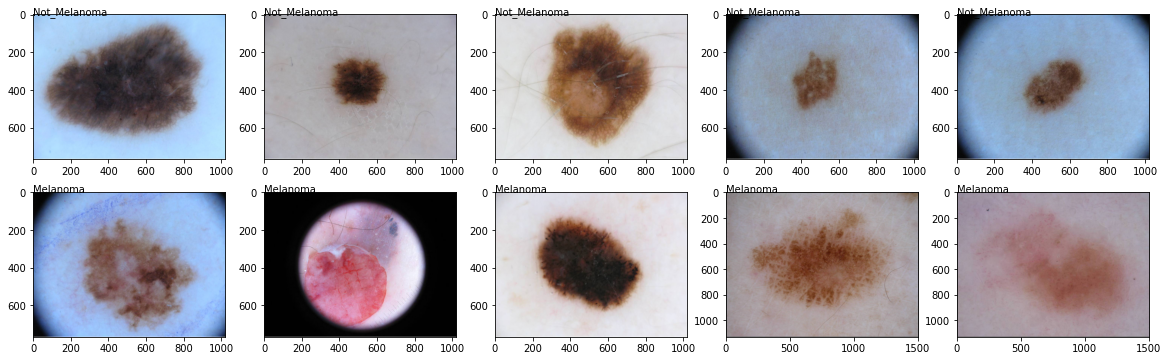

In [25]:
# Plot some training images from the dataset
nrows = 2
ncols = 5
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR)
    training_class_files = df_training['image_id'][df_training['class']==c_label]
    for j in range(ncols):
        training_examples.append(training_class_files.iloc[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(TRAIN_DIR + img_path)
    plt.imshow(img)
plt.show()

In [26]:
dataset_path = 'https://dainesanalytics.com/datasets/isic-challenge-2017/ISIC-2017_Validation_Part3_GroundTruth.csv'
df_validation = pd.read_csv(dataset_path, index_col=False)
df_validation['image_id'] = df_validation['image_id'] + '.jpg'
df_validation['melanoma'] = df_validation['melanoma'].astype(int)
df_validation['seborrheic_keratosis'] = df_validation['seborrheic_keratosis'].astype(int)
df_validation['class'] = CLASS_LABELS[0]
df_validation['class'][df_validation['melanoma']==1] = CLASS_LABELS[1]

# Take a peek at the dataframe after import
print(df_validation.head())

           image_id  melanoma  seborrheic_keratosis         class
0  ISIC_0001769.jpg         0                     0  Not_Melanoma
1  ISIC_0001852.jpg         0                     0  Not_Melanoma
2  ISIC_0001871.jpg         0                     0  Not_Melanoma
3  ISIC_0003462.jpg         0                     0  Not_Melanoma
4  ISIC_0003539.jpg         0                     0  Not_Melanoma


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [27]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(VALID_DIR)
    training_class_files = df_validation['image_id'][df_validation['class']==c_label]
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':')
    print(training_class_files[:5],'\n')

Number of training images for Not_Melanoma : 150
Training samples for Not_Melanoma :
0    ISIC_0001769.jpg
1    ISIC_0001852.jpg
2    ISIC_0001871.jpg
3    ISIC_0003462.jpg
4    ISIC_0003539.jpg
Name: image_id, dtype: object 

Number of training images for Melanoma : 150
Training samples for Melanoma :
25    ISIC_0012099.jpg
30    ISIC_0012151.jpg
42    ISIC_0012288.jpg
51    ISIC_0012434.jpg
73    ISIC_0013232.jpg
Name: image_id, dtype: object 



In [28]:
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="binary")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_dataframe(df_training,
                                                          directory=TRAIN_DIR,
                                                          x_col='image_id',
                                                          y_col='class',
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_dataframe(df_validation,
                                                              directory=VALID_DIR,
                                                              x_col='image_id',
                                                              y_col='class',
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 2000 validated image filenames belonging to 2 classes.
Number of training image batches per epoch of modeling: 63
Loading and pre-processing the validation images...
Found 150 validated image filenames belonging to 2 classes.
Number of validation image batches per epoch of modeling: 5


In [29]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [30]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [31]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [32]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.efficientnet.EfficientNetB7(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param)),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [33]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
reset_random()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(training_generator,
                                  epochs=MAX_EPOCHS,
                                  validation_data=validation_generator,
                                  callbacks=[learning_rate_reduction],
                                  verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

258088960/258076736 [==============================] - 4s 0us/step
Epoch 1/15
63/63 [==============================] - 350s 5s/step - loss: 3.4955 - accuracy: 0.7400 - val_loss: 28.3916 - val_accuracy: 0.2000
Epoch 2/15
63/63 [==============================] - 299s 5s/step - loss: 2.2938 - accuracy: 0.7760 - val_loss: 79.0851 - val_accuracy: 0.2000
Epoch 3/15
63/63 [==============================] - 299s 5s/step - loss: 1.7038 - accuracy: 0.8070 - val_loss: 14.3277 - val_accuracy: 0.2000
Epoch 4/15
63/63 [==============================] - 299s 5s/step - loss: 1.3148 - accuracy: 0.8045 - val_loss: 6.2036 - val_accuracy: 0.2067
Epoch 5/15
63/63 [==============================] - 297s 5s/step - loss: 0.7153 - accuracy: 0.8235 - val_loss: 1.6688 - val_accuracy: 0.4267
Epoch 6/15
63/63 [==============================] - 297s 5s/step - loss: 0.5066 - accuracy: 0.8480 - val_loss: 1.1125 - val_accuracy: 0.7733
Epoch 7/15
63/63 [==============================] - 296s 5s/step - loss: 0.4060 - ac

In [34]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
flatten (Flatten)            (None, 125440)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              256903168 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 321,002,904
Trainable params: 320,692,177
Non-trainable params: 310,727
_________________________________________________________________


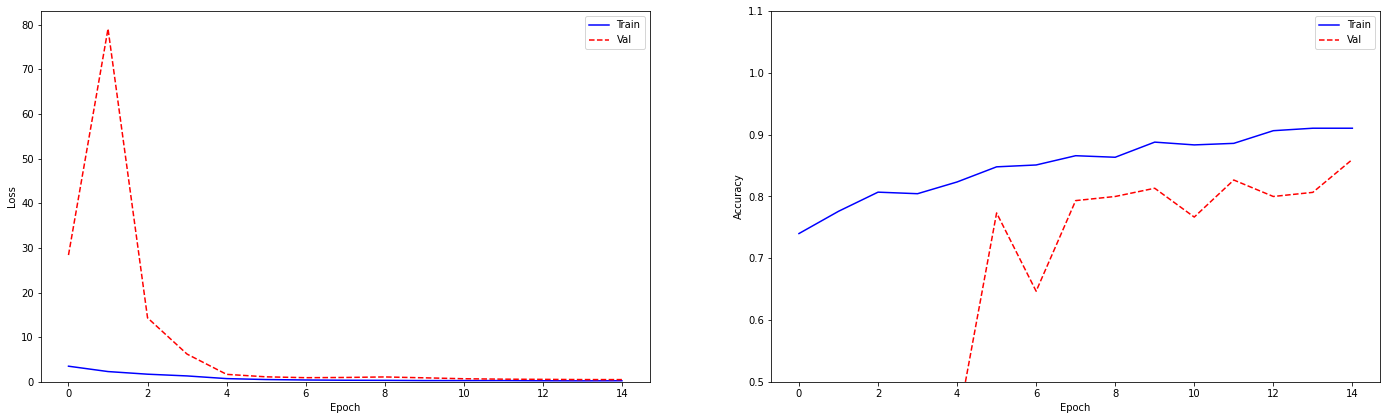

In [35]:
plot_metrics(nn_model_history)

In [36]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Not applicable for this iteration of modeling

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [37]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [38]:
datagen_kwargs = dict(rescale=1./255)
train_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="binary")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_dataframe(df_training,
                                                          directory=TRAIN_DIR,
                                                          x_col='image_id',
                                                          y_col='class',
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

Loading and pre-processing the training images...
Found 2000 validated image filenames belonging to 2 classes.
Number of training image batches per epoch of modeling: 63


In [39]:
# Prepare the final neural network model
start_time_module = datetime.now()
reset_random()
FINAL_LR = 0.0001
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=FINAL_LR)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(training_generator, epochs=MAX_EPOCHS, verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/15
63/63 [==============================] - 295s 4s/step - loss: 3.5213 - accuracy: 0.7430
Epoch 2/15
63/63 [==============================] - 266s 4s/step - loss: 2.4844 - accuracy: 0.7720
Epoch 3/15
63/63 [==============================] - 265s 4s/step - loss: 1.5389 - accuracy: 0.8095
Epoch 4/15
63/63 [==============================] - 265s 4s/step - loss: 1.1429 - accuracy: 0.8175
Epoch 5/15
63/63 [==============================] - 266s 4s/step - loss: 0.8690 - accuracy: 0.8250
Epoch 6/15
63/63 [==============================] - 266s 4s/step - loss: 0.5151 - accuracy: 0.8350
Epoch 7/15
63/63 [==============================] - 265s 4s/step - loss: 0.3854 - accuracy: 0.8550
Epoch 8/15
63/63 [==============================] - 265s 4s/step - loss: 0.3566 - accuracy: 0.8660
Epoch 9/15
63/63 [==============================] - 265s 4s/step - loss: 0.3164 - accuracy: 0.8790
Epoch 10/15
63/63 [==============================] - 265s 4s/step - loss: 0.3058 - accuracy: 0.8895
Epoch 11/

In [40]:
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
flatten_1 (Flatten)          (None, 125440)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              256903168 
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 321,002,904
Trainable params: 320,692,177
Non-trainable params: 310,727
_________________________________________________________________


In [41]:
dataset_path = 'https://dainesanalytics.com/datasets/isic-challenge-2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv'
df_test = pd.read_csv(dataset_path, index_col=False)
df_test['image_id'] = df_test['image_id'] + '.jpg'
df_test['melanoma'] = df_test['melanoma'].astype(int)
df_test['seborrheic_keratosis'] = df_test['seborrheic_keratosis'].astype(int)
df_test['class'] = CLASS_LABELS[0]
df_test['class'][df_test['melanoma']==1] = CLASS_LABELS[1]

# Take a peek at the dataframe after import
print(df_test.head())

           image_id  melanoma  seborrheic_keratosis         class
0  ISIC_0012086.jpg         0                     1  Not_Melanoma
1  ISIC_0012092.jpg         0                     0  Not_Melanoma
2  ISIC_0012095.jpg         0                     0  Not_Melanoma
3  ISIC_0012134.jpg         0                     1  Not_Melanoma
4  ISIC_0012136.jpg         0                     1  Not_Melanoma


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [42]:
print('Loading and pre-processing the testing images...')
test_datagen = ImageDataGenerator(**datagen_kwargs)
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  directory=TEST_DIR,
                                                  x_col='image_id',
                                                  y_col='class',
                                                  target_size=TARGET_IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False,
                                                  **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(test_generator))

Loading and pre-processing the testing images...
Found 600 validated image filenames belonging to 2 classes.
Number of image batches per epoch of modeling: 19


In [43]:
final_model.evaluate(test_generator, verbose=1)

19/19 [==============================] - 210s 11s/step - loss: 0.7833 - accuracy: 0.7283


[0.7833402752876282, 0.7283333539962769]

In [44]:
test_predictions = (final_model.predict(test_generator) > 0.5).astype('int').ravel()
test_originals = test_generator.labels
print('Accuracy Score:', accuracy_score(test_originals, test_predictions))
print(confusion_matrix(test_originals, test_predictions))
print(classification_report(test_originals, test_predictions))

Accuracy Score: 0.7283333333333334
[[ 58  59]
 [104 379]]
              precision    recall  f1-score   support

           0       0.36      0.50      0.42       117
           1       0.87      0.78      0.82       483

    accuracy                           0.73       600
   macro avg       0.61      0.64      0.62       600
weighted avg       0.77      0.73      0.74       600



In [45]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [46]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 2:48:14.592046
